# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [26]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [27]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

Clear previously loaded data.


## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your interests.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [28]:
from cs231n.features import *

# 10, 11, 
num_color_bins = 16 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [13]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [5e-8, 1e-7, 2e-7, 3e-7, 4e-7, 5e-7, 1e-6, 5e-6]
regularization_strengths = [1e3, 5e3, 1e4, 2e4, 3e4, 4e4, 5e4, 1e5]

results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.
best_params = None


################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
for l in learning_rates:
    for r in regularization_strengths:
        svm = LinearSVM()
        curr_loss = svm.train(X_train_feats, y_train, learning_rate=l, reg=r,
                      num_iters=1500, verbose=True)
        y_train_pred = svm.predict(X_train_feats)
        y_train_acc = np.mean(y_train == y_train_pred)
        y_val_pred = svm.predict(X_val_feats)
        y_val_acc = np.mean(y_val == y_val_pred)
        results[(l, r)] = (y_train_acc, y_val_acc)
        if y_val_acc > best_val:
            best_svm = svm 
            best_val = y_val_acc
            best_params = (l, r)
            
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)
print best_params

iteration 0 / 1500: loss 10.596329
iteration 100 / 1500: loss 10.578521
iteration 200 / 1500: loss 10.546396
iteration 300 / 1500: loss 10.499155
iteration 400 / 1500: loss 10.469077
iteration 500 / 1500: loss 10.447657
iteration 600 / 1500: loss 10.414133
iteration 700 / 1500: loss 10.401073
iteration 800 / 1500: loss 10.364895
iteration 900 / 1500: loss 10.327907
iteration 1000 / 1500: loss 10.310513
iteration 1100 / 1500: loss 10.287885
iteration 1200 / 1500: loss 10.259661
iteration 1300 / 1500: loss 10.233150
iteration 1400 / 1500: loss 10.191958
iteration 0 / 1500: loss 16.635261
iteration 100 / 1500: loss 15.920372
iteration 200 / 1500: loss 15.261402
iteration 300 / 1500: loss 14.666318
iteration 400 / 1500: loss 14.126514
iteration 500 / 1500: loss 13.648507
iteration 600 / 1500: loss 13.197804
iteration 700 / 1500: loss 12.798200
iteration 800 / 1500: loss 12.440185
iteration 900 / 1500: loss 12.117257
iteration 1000 / 1500: loss 11.824610
iteration 1100 / 1500: loss 11.54493

iteration 0 / 1500: loss 169.096718
iteration 100 / 1500: loss 11.814801
iteration 200 / 1500: loss 9.049346
iteration 300 / 1500: loss 9.000670
iteration 400 / 1500: loss 8.999870
iteration 500 / 1500: loss 8.999839
iteration 600 / 1500: loss 8.999842
iteration 700 / 1500: loss 8.999862
iteration 800 / 1500: loss 8.999791
iteration 900 / 1500: loss 8.999797
iteration 1000 / 1500: loss 8.999793
iteration 1100 / 1500: loss 8.999786
iteration 1200 / 1500: loss 8.999813
iteration 1300 / 1500: loss 8.999809
iteration 1400 / 1500: loss 8.999826
iteration 0 / 1500: loss 10.604011
iteration 100 / 1500: loss 10.472676
iteration 200 / 1500: loss 10.364896
iteration 300 / 1500: loss 10.261710
iteration 400 / 1500: loss 10.167433
iteration 500 / 1500: loss 10.074861
iteration 600 / 1500: loss 9.979947
iteration 700 / 1500: loss 9.914838
iteration 800 / 1500: loss 9.828529
iteration 900 / 1500: loss 9.781575
iteration 1000 / 1500: loss 9.710182
iteration 1100 / 1500: loss 9.670637
iteration 1200 /

iteration 100 / 1500: loss 9.181799
iteration 200 / 1500: loss 9.000124
iteration 300 / 1500: loss 8.999649
iteration 400 / 1500: loss 8.999701
iteration 500 / 1500: loss 8.999619
iteration 600 / 1500: loss 8.999628
iteration 700 / 1500: loss 8.999640
iteration 800 / 1500: loss 8.999594
iteration 900 / 1500: loss 8.999611
iteration 1000 / 1500: loss 8.999734
iteration 1100 / 1500: loss 8.999569
iteration 1200 / 1500: loss 8.999629
iteration 1300 / 1500: loss 8.999596
iteration 1400 / 1500: loss 8.999583
iteration 0 / 1500: loss 161.811135
iteration 100 / 1500: loss 9.000467
iteration 200 / 1500: loss 8.999852
iteration 300 / 1500: loss 8.999852
iteration 400 / 1500: loss 8.999797
iteration 500 / 1500: loss 8.999783
iteration 600 / 1500: loss 8.999849
iteration 700 / 1500: loss 8.999827
iteration 800 / 1500: loss 8.999826
iteration 900 / 1500: loss 8.999832
iteration 1000 / 1500: loss 8.999842
iteration 1100 / 1500: loss 8.999863
iteration 1200 / 1500: loss 8.999851
iteration 1300 / 150

iteration 200 / 1500: loss 8.999580
iteration 300 / 1500: loss 8.999650
iteration 400 / 1500: loss 8.999458
iteration 500 / 1500: loss 8.999642
iteration 600 / 1500: loss 8.999487
iteration 700 / 1500: loss 8.999515
iteration 800 / 1500: loss 8.999649
iteration 900 / 1500: loss 8.999542
iteration 1000 / 1500: loss 8.999501
iteration 1100 / 1500: loss 8.999602
iteration 1200 / 1500: loss 8.999582
iteration 1300 / 1500: loss 8.999585
iteration 1400 / 1500: loss 8.999560
iteration 0 / 1500: loss 86.802750
iteration 100 / 1500: loss 9.002371
iteration 200 / 1500: loss 8.999649
iteration 300 / 1500: loss 8.999634
iteration 400 / 1500: loss 8.999653
iteration 500 / 1500: loss 8.999657
iteration 600 / 1500: loss 8.999642
iteration 700 / 1500: loss 8.999632
iteration 800 / 1500: loss 8.999622
iteration 900 / 1500: loss 8.999620
iteration 1000 / 1500: loss 8.999635
iteration 1100 / 1500: loss 8.999676
iteration 1200 / 1500: loss 8.999669
iteration 1300 / 1500: loss 8.999626
iteration 1400 / 150

iteration 300 / 1500: loss 8.999709
iteration 400 / 1500: loss 8.999482
iteration 500 / 1500: loss 8.999421
iteration 600 / 1500: loss 8.999578
iteration 700 / 1500: loss 8.999588
iteration 800 / 1500: loss 8.999414
iteration 900 / 1500: loss 8.999363
iteration 1000 / 1500: loss 8.999493
iteration 1100 / 1500: loss 8.999473
iteration 1200 / 1500: loss 8.999486
iteration 1300 / 1500: loss 8.999490
iteration 1400 / 1500: loss 8.999658
iteration 0 / 1500: loss 74.177490
iteration 100 / 1500: loss 8.999791
iteration 200 / 1500: loss 8.999668
iteration 300 / 1500: loss 8.999729
iteration 400 / 1500: loss 8.999738
iteration 500 / 1500: loss 8.999627
iteration 600 / 1500: loss 8.999656
iteration 700 / 1500: loss 8.999694
iteration 800 / 1500: loss 8.999696
iteration 900 / 1500: loss 8.999695
iteration 1000 / 1500: loss 8.999639
iteration 1100 / 1500: loss 8.999769
iteration 1200 / 1500: loss 8.999578
iteration 1300 / 1500: loss 8.999685
iteration 1400 / 1500: loss 8.999714
iteration 0 / 1500:

In [14]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.426


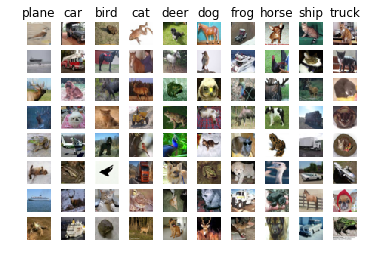

In [15]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

Some seem to make sense - for example, peripheral view of bird that can arguably look like a plane taking off or a dog on a grassy field standing on 4 legs mistaken for a horse. But many other misclassifications are hard to interpret.

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [29]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 161)
(49000, 160)


In [33]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
results = {}
best_val = -1
best_net = None
best_params = None
learning_rates = [1e-1, 5e-1, 1e0]
regularization_strengths = [1e-3, 5e-3, 1e-2]

for l in learning_rates:
    for r in regularization_strengths:
        print(l)
        net = TwoLayerNet(input_dim, hidden_dim, num_classes)
        curr_loss = net.train(X_train_feats, y_train, X_val_feats, y_val, learning_rate=l, reg=r, num_iters=1500)
        y_train_pred = net.predict(X_train_feats)
        y_train_acc = np.mean(y_train == y_train_pred)
        y_val_pred = net.predict(X_val_feats)
        y_val_acc = np.mean(y_val == y_val_pred)
        results[(l, r)] = (y_train_acc, y_val_acc)
        if y_val_acc > best_val:
            best_net = net
            best_val = y_val_acc
            best_params = (l, r)


################################################################################
#                              END OF YOUR CODE                                #
################################################################################
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)
print(best_params)

0.1
0.1
0.1
0.5
0.5
0.5
1.0
1.0
1.0
lr 1.000000e-01 reg 1.000000e-03 train accuracy: 0.540918 val accuracy: 0.525000
lr 1.000000e-01 reg 5.000000e-03 train accuracy: 0.528388 val accuracy: 0.514000
lr 1.000000e-01 reg 1.000000e-02 train accuracy: 0.521020 val accuracy: 0.520000
lr 5.000000e-01 reg 1.000000e-03 train accuracy: 0.660694 val accuracy: 0.597000
lr 5.000000e-01 reg 5.000000e-03 train accuracy: 0.565143 val accuracy: 0.559000
lr 5.000000e-01 reg 1.000000e-02 train accuracy: 0.514714 val accuracy: 0.500000
lr 1.000000e+00 reg 1.000000e-03 train accuracy: 0.671020 val accuracy: 0.560000
lr 1.000000e+00 reg 5.000000e-03 train accuracy: 0.555163 val accuracy: 0.519000
lr 1.000000e+00 reg 1.000000e-02 train accuracy: 0.509469 val accuracy: 0.486000
best validation accuracy achieved during cross-validation: 0.597000
(0.5, 0.001)


In [34]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.577
